# LightGBM model

Since we don't have a lot of history but many categorical columns, it could make sense to train a boosted method.  
This tends to be particularly useful when the forecasting horizon is very large, like in our case.  

I've been experimenting with different aggregations, i.e. daily, weekly, monthly (the code is general enough to manage all frequencies) and the monthly option looks like the best one.  
It imples we're loosing a lot of information (product related, about stores, etc.) but the coarse aggregation reduces variance, fluctuatins and intermittency.

__SUMMARY__

1. Load data
2. Preprocess data
    - Set types to columns
    - Filter based on time
    - Remove outliers
    - Aggregate data a the monthly frequency
    - Fill in missing dates (so that we won't have issues while building lagged features)
3. Feature generation
    - Time related features (month, year, sin(month), etc)
    - Lagged features (>= 12 to avoid data leakage)
    - Shifted rolling features
    - Period features
4. Hyperparameters optimisation (with time series split)
5. Model evaluation
6. Plot predictions

### 1. Load data

In [1]:
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMRegressor
from utils.utils_models import LightGBMForecastingModel

import utils.utils_preprocessing as utils_preprocessing
import utils.utils_features as utils_features

In [2]:
df_sales = pd.read_parquet("data/sales.parquet")
df_products = pd.read_parquet("data/products.parquet")
df = df_sales.merge(df_products, on="product_id")

### 2. Preprocess data

In [3]:
df = utils_preprocessing.set_types(df)
df = utils_preprocessing.filter_dates(df, date="2024-09-01")
df = utils_preprocessing.remove_outliers(df, window_size=5, threshold=2)

df_monthly = utils_preprocessing.aggregate_data(
    df, 
    frequency="ME"
    )
df_monthly = utils_preprocessing.fill_in_missing_dates(
    df_monthly, 
    group_col=["brand", "family"], 
    date_col="date", 
    freq="ME"
    )

### 3. Feature generation

In [4]:
df_monthly = utils_features.features_time_related(
    df_monthly, 
    frequency='ME'
    )
df_monthly = utils_features.features_lag(
    df=df_monthly, 
    col="total_revenue",
    lags=[12, 13, 14],
    group_column=['brand', 'family']
)
df_monthly = utils_features.features_rolling(
    df=df_monthly, 
    col="total_revenue",
    window_sizes=[3, 5],
    group_column=['brand', 'family']
)
df_monthly = utils_features.create_periods_feature(
    df_monthly, 
    group_col=['brand', 'family'], 
    date_col='date', 
    target_col='total_revenue'
    )

In [5]:
cols_categorical = ['brand', 'family']
for col in cols_categorical:
    df_monthly[col] = df_monthly[col].astype("category")
df_monthly = df_monthly.rename(columns={"total_revenue": "y"}).set_index("date")

In [6]:
df_monthly.tail()

,brand,family,y,year,month_of_year,sin_month_of_year,cos_month_of_year,total_revenue_lag_12,total_revenue_lag_13,total_revenue_lag_14,total_revenue_rolling_mean_3w,total_revenue_rolling_std_3w,total_revenue_rolling_sum_3w,total_revenue_rolling_mean_5w,total_revenue_rolling_std_5w,total_revenue_rolling_sum_5w,feature_periods
date,,,,,,,,,,,,,,,,,
2024-03-31,adidas,Zuecos Urban,99.949997,2024,3,1.000,0.000,99.949997,99.949997,99.949997,99.949997,0.000000,299.849991,163.950003,87.635618,819.750015,32.0
2024-04-30,adidas,Zuecos Urban,99.949997,2024,4,0.866,-0.500,299.849976,99.949997,99.949997,166.583323,115.412306,499.749969,171.929996,99.567069,859.649979,33.0
2024-05-31,adidas,Zuecos Urban,199.899994,2024,5,0.500,-0.866,299.849976,299.849976,99.949997,233.216649,115.412306,699.649948,179.909988,109.489728,899.549942,34.0
2024-06-30,adidas,Zuecos Urban,99.949997,2024,6,0.000,-1.000,299.849976,299.849976,299.849976,299.849976,0.000000,899.549927,219.889984,109.489728,1099.449921,35.0
2024-07-31,adidas,Zuecos Urban,99.949997,2024,7,-0.500,-0.866,199.899994,299.849976,299.849976,266.533315,57.706149,799.599945,239.879984,89.397987,1199.399918,36.0


### 4. Hyperparameters optimisation

In [7]:
X_train, X_test, y_train, y_test = utils_preprocessing.train_test_split(df_monthly, forecasting_horizon=12, target_col="y")

In [8]:
cv_split = TimeSeriesSplit(n_splits=3, test_size=12)

In [9]:
parameters = {
    'objective': ['regression'],
    "boosting_type": ["gbdt"],
    'metric': ['rmse'],
    'importance_type': ['split'],
    'verbosity': [-1],
    "max_depth": [-1, 1, 3, 4, 5, 6, 10],
    "num_leaves": [10, 20, 30, 40, 100, 120, 150, 200, 250],
    "learning_rate": [0.01, 0.1, 0.2, 0.3, 0.4, 0.5],
    "n_estimators": [50, 100, 300, 500, 700, 900, 1000],
    "colsample_bytree": [0.3, 0.5, 0.7, 1, 1.2, 1.5],
    "reg_alpha": [0, 0.01, 1, 2, 5, 7, 10, 50, 100],
    "reg_lambda": [0, 0.01, 1, 5, 10, 20, 50, 100]
}


random_search = RandomizedSearchCV(
    estimator=LGBMRegressor(), 
    cv=cv_split, 
    param_distributions=parameters,
    verbose=1
    )
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /Users/runner/work/LightGBM/LightGBM/lightgbm-python/src/io/config_auto.cpp, line 385 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /Users/runner/work/LightGBM/LightGBM/lightgbm-python/src/io/config_auto.cpp, line 385 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /Users/runner/work/LightGBM/LightGBM/lightgbm-python/src/io/config_auto.cpp, line 385 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /Users/runner/work/LightGBM/LightGBM/lightgbm-python/src/io/config_auto.cpp, line 385 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /Users/runner/work/LightGBM/LightGBM/lightgbm-python/src/io/config_auto.cpp, line 385 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /Users/runner/work/LightGBM/LightGBM/lightgbm-python/src/io/config_auto.cpp, line 385 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /Users/runner/work

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=12),
                   estimator=LGBMRegressor(),
                   param_distributions={'boosting_type': ['gbdt'],
                                        'colsample_bytree': [0.3, 0.5, 0.7, 1,
                                                             1.2, 1.5],
                                        'importance_type': ['split'],
                                        'learning_rate': [0.01, 0.1, 0.2, 0.3,
                                                          0.4, 0.5],
                                        'max_depth': [-1, 1, 3, 4, 5, 6, 10],
                                        'metric': ['rmse'],
                                        'n_estimators': [50, 100, 300, 500, 700,
                                                         900, 1000],
                                        'num_leaves': [10, 20, 30, 40, 100, 120,
                                                       150, 200, 250],
                                        'objective': ['regression'],
                                        'reg_alpha': [0, 0.01, 1, 2, 5, 7, 10,
                                                      50, 100],
                                        'reg_lambda': [0, 0.01, 1, 5, 10, 20,
                                                       50, 100],
                                        'verbosity': [-1]},
                   verbose=1)

In [10]:
best_model = random_search.best_estimator_
optimal_params = best_model.get_params()

In [11]:
optimal_params

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1,
 'importance_type': 'split',
 'learning_rate': 0.01,
 'max_depth': 6,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 500,
 'n_jobs': None,
 'num_leaves': 150,
 'objective': 'regression',
 'random_state': None,
 'reg_alpha': 100,
 'reg_lambda': 0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'verbosity': -1,
 'metric': 'rmse'}

In [12]:
{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 0.3,
 'importance_type': 'split',
 'learning_rate': 0.01,
 'max_depth': 4,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 500,
 'n_jobs': None,
 'num_leaves': 100,
 'objective': 'regression',
 'random_state': None,
 'reg_alpha': 10,
 'reg_lambda': 0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'verbosity': -1,
 'metric': 'rmse'}

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 0.3,
 'importance_type': 'split',
 'learning_rate': 0.01,
 'max_depth': 4,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 500,
 'n_jobs': None,
 'num_leaves': 100,
 'objective': 'regression',
 'random_state': None,
 'reg_alpha': 10,
 'reg_lambda': 0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'verbosity': -1,
 'metric': 'rmse'}

### 5. Model evaluation

In [19]:
tss = TimeSeriesSplit(2, test_size=12)

fc_model = LightGBMForecastingModel(hyperparameters=optimal_params)
results_cv = fc_model.cross_validate(df_monthly, n_splits=2)

Train [2020-09-30 - 2022-08-31]
Predict [2022-09-30 - 2023-08-31]
Train [2020-09-30 - 2023-08-31]
Predict [2023-09-30 - 2024-08-31]
Average RMSE from cross-validation: 18487.9500


In [13]:
results_cv = fc_model.cross_validate(df_monthly, n_splits=2, metric='MAPE')

Train [2020-09-30 - 2022-08-31]
Predict [2022-09-30 - 2023-08-31]
Train [2020-09-30 - 2023-08-31]
Predict [2023-09-30 - 2024-08-31]
Average MAPE from cross-validation: 0.7950


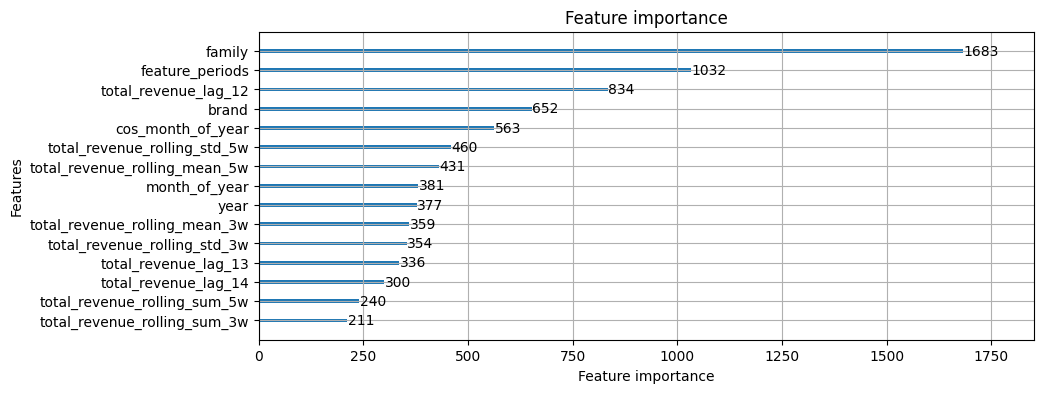

In [14]:
fc_model.plot_feature_importance()

### 6. Plot predictions

In [15]:
y_preds = fc_model.predict(X=X_test)
df_preds = pd.DataFrame(
    data={
        "brand": X_test["brand"],
        "family": X_test["family"],
        "y_pred": y_preds,
        "y": y_test.values
    },
    index=X_test.index,
)

<Axes: xlabel='date'>

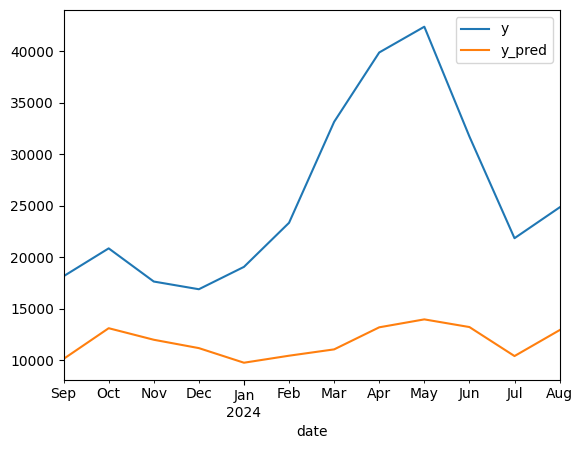

In [18]:
family = "Zapatillas Urban"
brand = "adidas"
df_preds[(df_preds["family"] == family) & (df_preds["brand"] == brand)][["y", "y_pred"]].plot()